# Convolutional Neural Networks: Getting Started

Let's do an image classification problem, with a data set of 32x32 color images that are categorized into one of ten classifications of what's in them. (32x32 is a very small image! So this isn't easy.)

We're just going to show that this *can* work for now, and expand upon this example later in the course to make it work better and much more efficiently. 

CNN's are very computationally intensive, and the only way you can run them in a reasonable amount of time is by installing the tensorflow-gpu package. This is a little bit tricky, so it's OK if you just want to look at this notebook without actually running it yourself. The specifics of getting tensorflow-gpu running depends on both the version of Tensorflow you installed, and your operating system. Please refer to https://www.tensorflow.org/install/ for instructions. You may have to create a developer account with NVidia in order to get some of the components you need. Note you need an NVidia GPU for tensorflow-gpu to work at all; if you don't have one, just watch.

Let's start by defining the topology of our CNN. We'll start very simply - a single Conv2D layer, followed by a Dropout layer to prevent overfitting, which then gets flattened into a conventional deep neural network, with 512 neurons, a 50% dropout layer, and the final layer for our 10 possible classification results.



In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
    
def createModel(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
     
    return model

We're going to train this neural network with the "cifar10" data set, which is built into Keras. It's 50,000 training images, and 10,000 test images - again, all of them 32x32 color images that represent one of ten different things.

Let's load it up, and convert the labels into "one-hot" format which makes them suitable for use in a neural network. After printing the shape of the training data and the size of the training and testing data sets as a sanity check, we'll illustrate one-hot, or "categorical" encoding by displaying one raw label and its one-hot representation as a binary array.

In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(x_train.shape[0])
print(x_test.shape[0])

print (y_test[0])
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print (y_test[0])

(50000, 32, 32, 3)
50000
10000
[3]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


It's always a good idea to get an intuitive feel of the data you're dealing with, so let's display nine sample images from our training data, along with their labels. You can see here what the different categories represent, too.

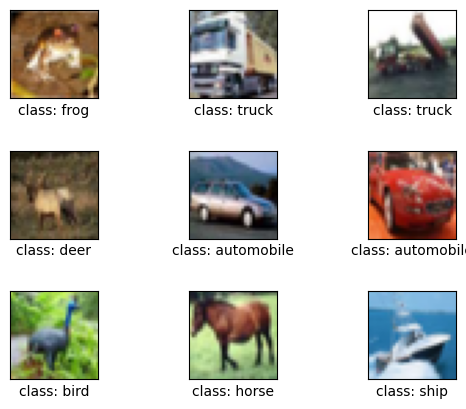

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])

    xlabel = "class: {0}".format(class_names[y_train[i].argmax()])

    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])


Just like we had to convert our labels into a format appropriate for a neural network, we also need to convert our feature data (the images themselves) into a suitable format. Neural network like normalized data as inputs, so we'll convert our image pixel data from 8-bit values that range from 0-255 into floating point values that range from 0-1:

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Now we can create and compile our CNN model. We'll use the RMSprop optimizer, create our model, and compile it.

In [8]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

model = createModel(x_train.shape[1:])

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

H:\anaconda3-fresh\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's have Keras output the topology to make sure it matches what we want.

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,783,754 (64.02 MB)

 Trainable params: 16,783,754 (64.02 MB)

 Non-trainable params: 0 (0.00 B)

Now let's actually train our neural network. In the interests of time, we'll just run 10 epochs because we haven't taken steps you'd normally take to make this run faster. But, let's see how long it takes to train this network over 10 epochs:

In [10]:
import time

start_time = time.time()

model.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test),
          shuffle=True)

elapsed_time = time.time() - start_time

print(elapsed_time)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.2831 - loss: 1.9991 - val_accuracy: 0.4516 - val_loss: 1.5611
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.4451 - loss: 1.5620 - val_accuracy: 0.5063 - val_loss: 1.3949
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 80ms/step - accuracy: 0.5023 - loss: 1.4093 - val_accuracy: 0.5396 - val_loss: 1.2982
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - accuracy: 0.5464 - loss: 1.2930 - val_accuracy: 0.5623 - val_loss: 1.2314
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 0.5699 - loss: 1.2262 - val_accuracy: 0.5823 - val_loss: 1.1946
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 80ms/step - accuracy: 0.5896 - loss: 1.1655 - val_accuracy: 0.5782 - val_loss: 1.2119
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 80ms/step - accuracy: 0.6091 - loss: 1.1198 - val_accuracy: 0.5911 - val_loss: 1.1497
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 

Now, let's measure the accuracy of our CNN against our test data:

In [11]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6011 - loss: 1.1404
Test loss: 1.1515748500823975
Test accuracy: 0.5956000089645386


60%? Not that great. The accuracy was improving pretty quickly with every epoch though, so if we let it run longer we'd probably get much better results. It just takes an annoyingly long amount of time to do that, even when using tensorflow-gpu. But, we'll address that shortly!

To get an intuitive feel of just how good or bad our resulting model is, let's go through the first 100 test images and display the ones it got wrong. Are these errors understandable, or just a model that's embarassingly worse than a human?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


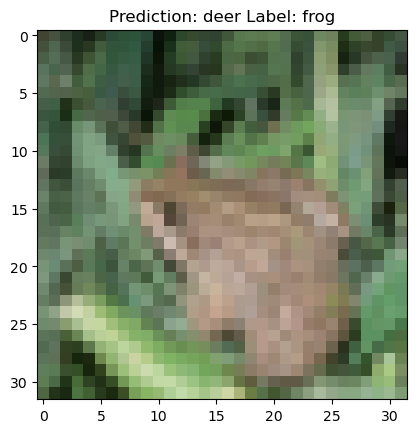

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


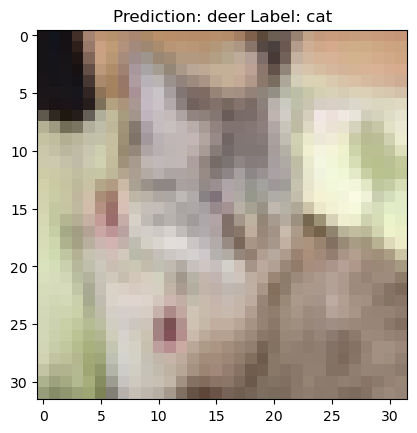

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


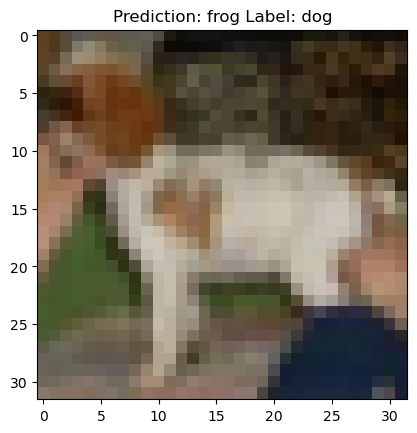

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


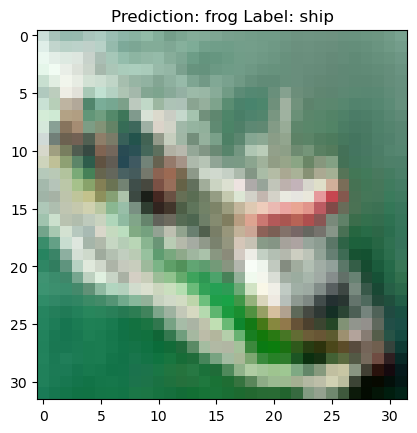

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


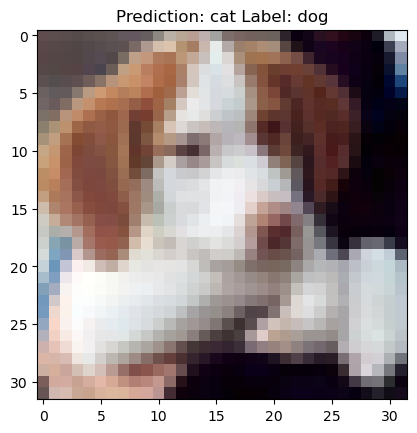

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


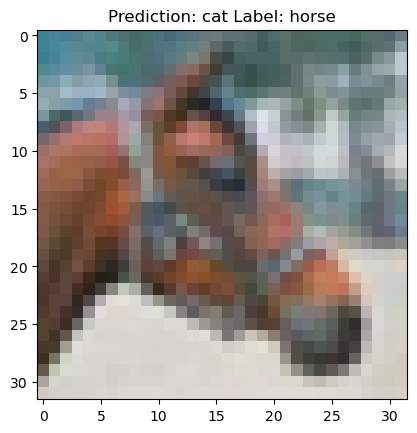

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


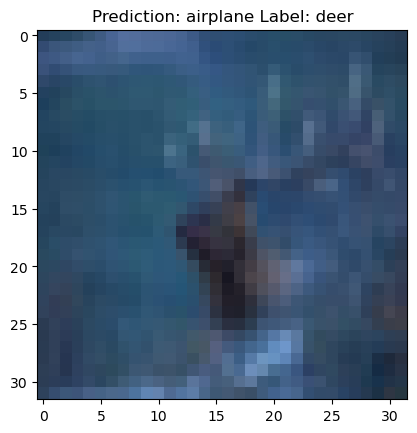

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


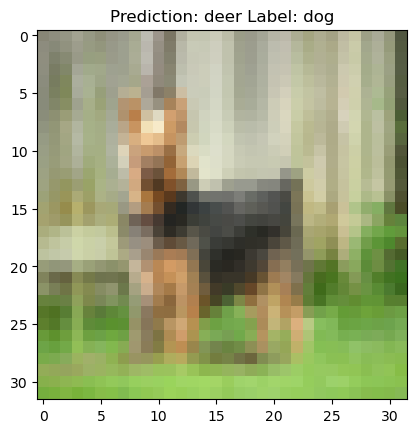

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


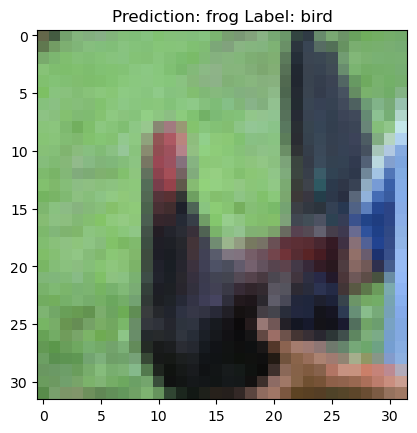

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


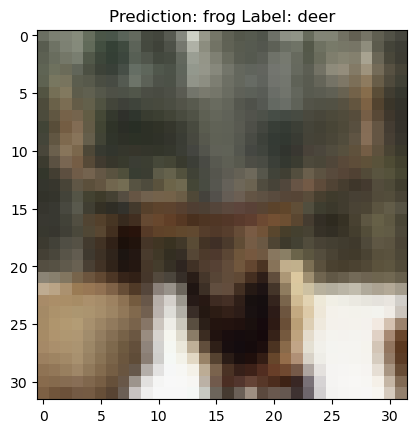

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


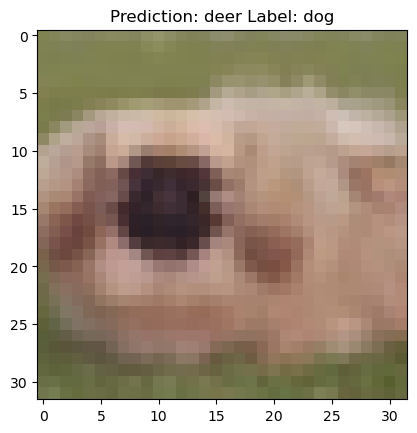

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


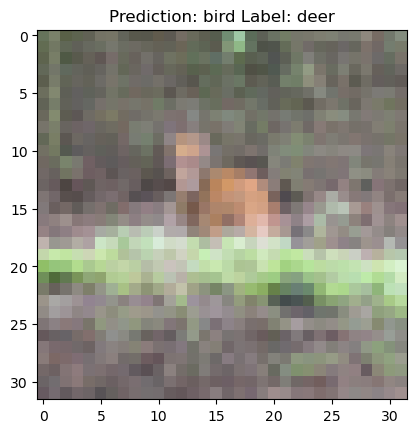

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


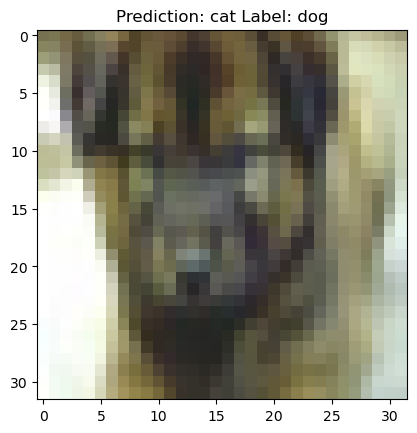

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


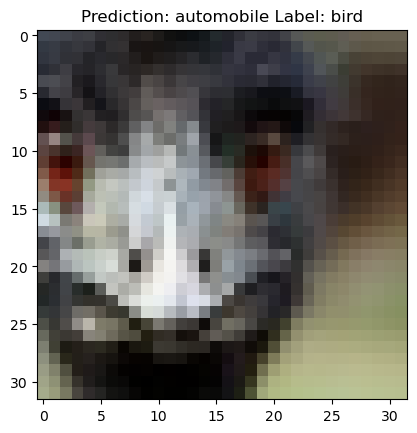

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


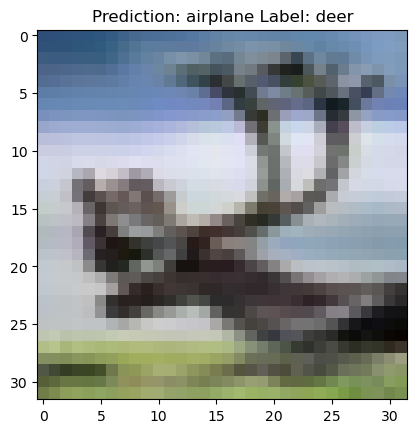

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


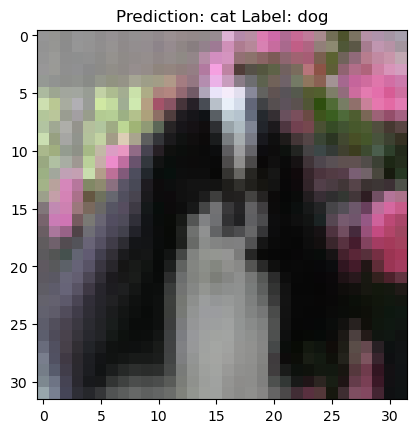

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


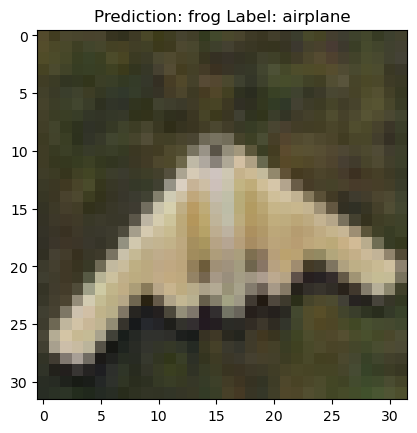

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


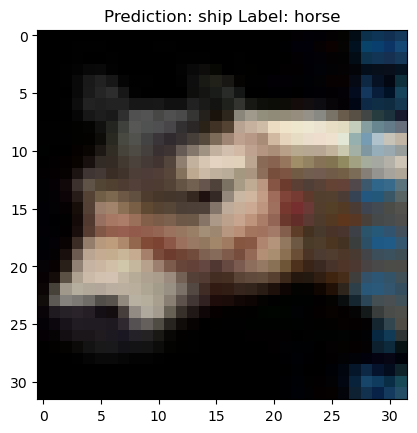

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


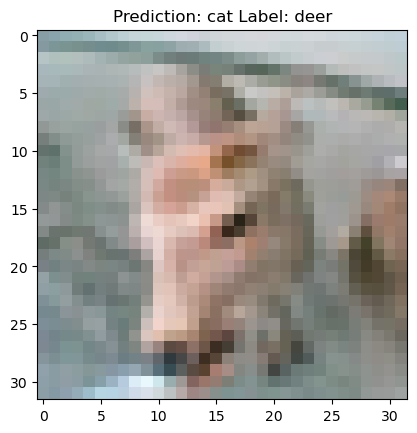

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


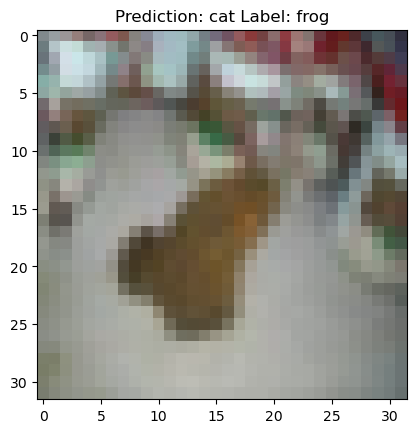

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


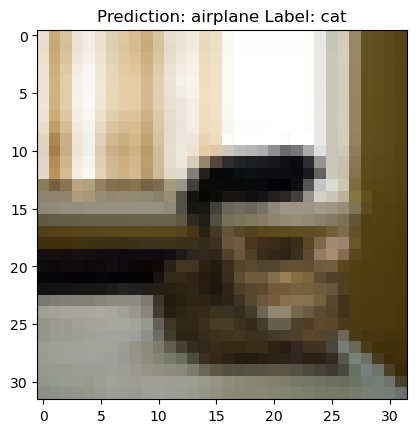

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


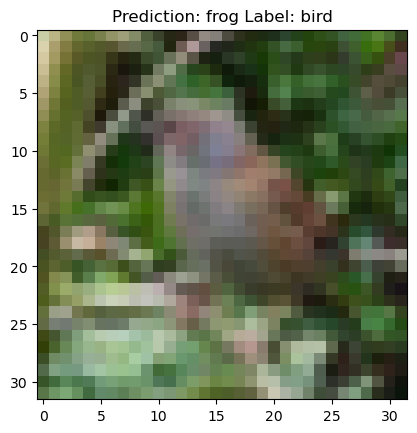

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


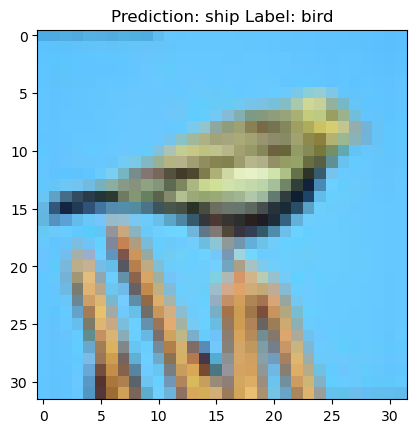

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


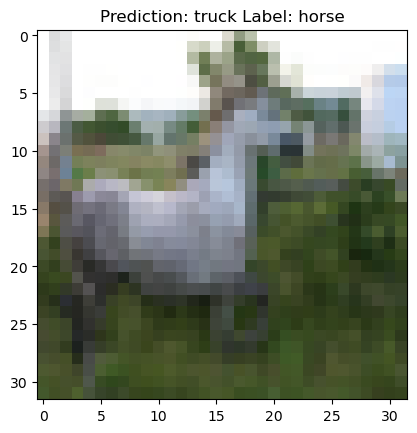

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


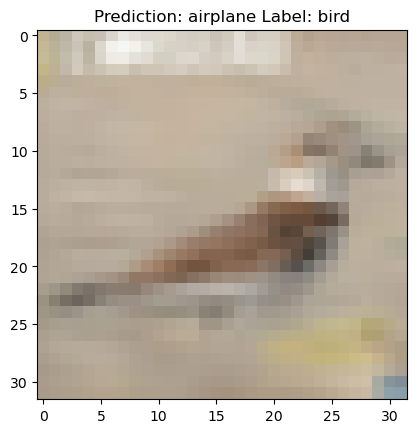

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


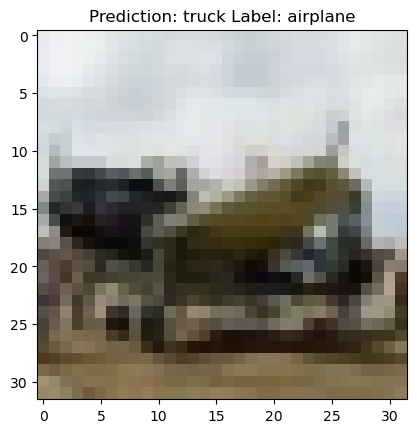

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


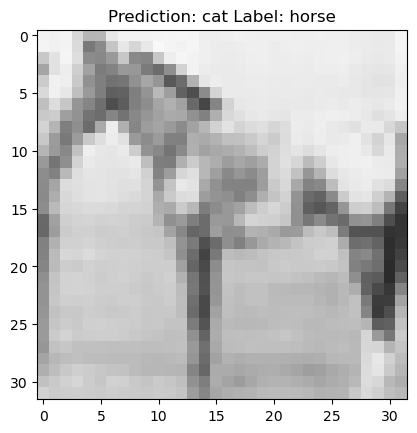

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


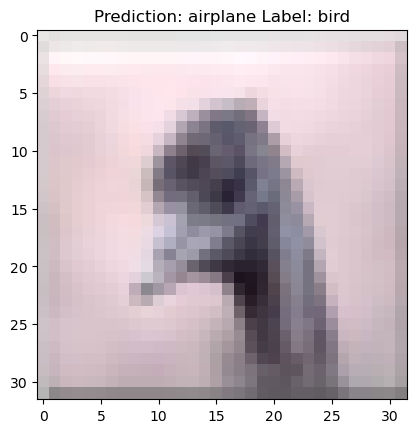

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


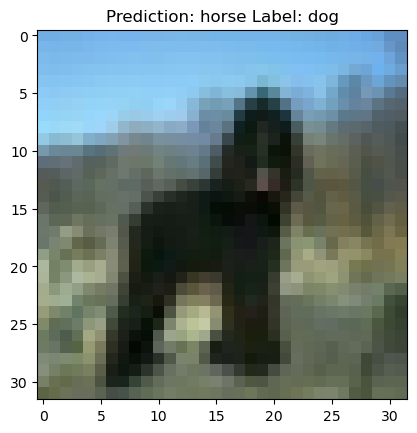

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


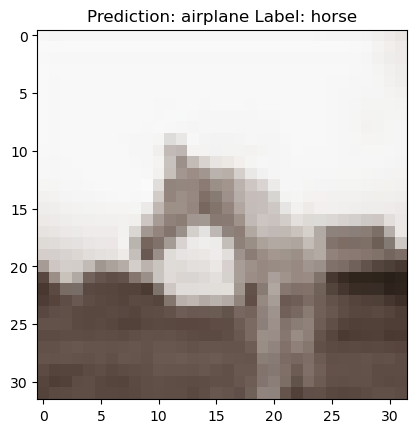

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


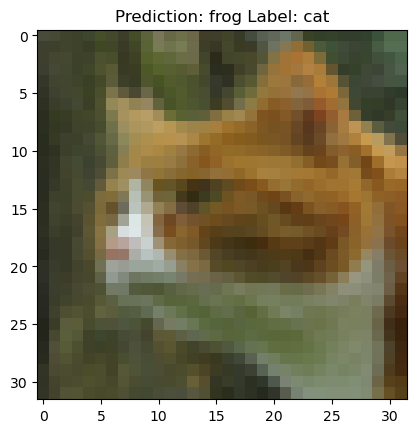

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [12]:
for x in range(100):
    test_image = x_test[x,:]
    predicted_cat = model.predict(np.array([test_image])).argmax()
    label = y_test[x].argmax()
    if (predicted_cat != label):
        plt.title('Prediction: %s Label: %s' % (class_names[predicted_cat], class_names[label]))
        plt.imshow(test_image)
        plt.show()

Yeah, it's pretty bad. But CNN's are actually very powerful - we just haven't tuned it with the right topology, we haven't made it efficient enough to run enough epochs, and there are some other tricks we can use as well. Don't give up on them! We're about to improve on this model substantially.